### Air Passengers forecasting

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab 


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy.special import boxcox, inv_boxcox
from scipy import stats
from pmdarima import auto_arima

plt.rcParams['figure.figsize']=(17,5)
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("Database/Airlines+Data.xlsx",parse_dates=["Month"])
df.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [3]:
df.shape

(96, 2)

In [4]:
df.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [5]:
df.isna().sum()

Month         0
Passengers    0
dtype: int64

<AxesSubplot:>

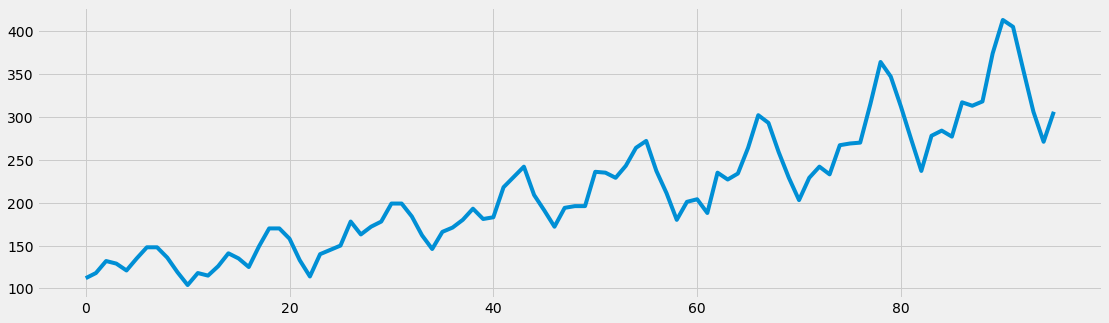

In [6]:
df['Passengers'].plot()

<AxesSubplot:xlabel='Passengers', ylabel='Density'>

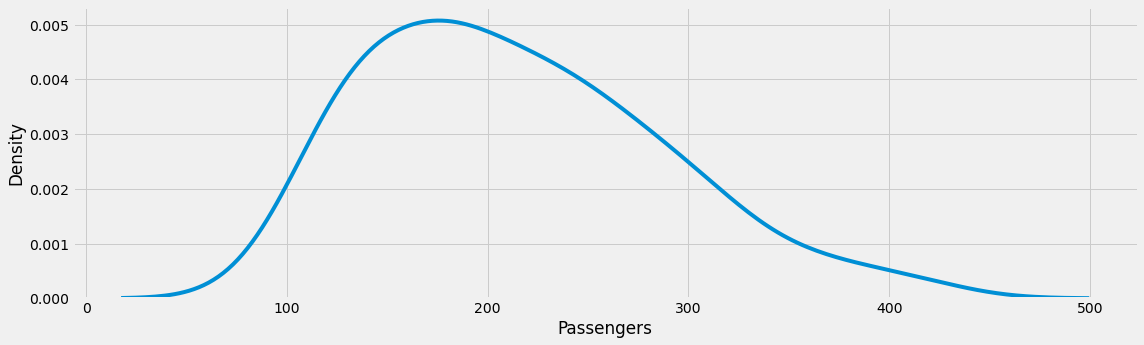

In [7]:
sns.distplot(df['Passengers'], hist=False)

In [8]:
df['month'] = df['Month'].dt.strftime('%b')
df.head()

,Month,Passengers,month
0,1995-01-01,112,Jan
1,1995-02-01,118,Feb
2,1995-03-01,132,Mar
3,1995-04-01,129,Apr
4,1995-05-01,121,May


In [9]:
dummies  = pd.DataFrame(pd.get_dummies(df['month']))

In [10]:
dfs = pd.concat([df,dummies],axis=1)

In [11]:
dfs.head()

,Month,Passengers,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,Jan,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,Feb,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,Mar,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,Apr,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,May,0,0,0,0,0,0,0,0,1,0,0,0


In [12]:
dfs['year']=dfs['Month'].dt.strftime('%y')

In [13]:
dfs['t'] = np.arange(1,97)
dfs['t_sqr'] = dfs['t']*dfs['t']
dfs['log_passengers'] = np.log(dfs['Passengers'])
dfs.head()

,Month,Passengers,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,year,t,t_sqr,log_passengers
0,1995-01-01,112,Jan,0,0,0,0,1,0,0,0,0,0,0,0,95,1,1,4.718499
1,1995-02-01,118,Feb,0,0,0,1,0,0,0,0,0,0,0,0,95,2,4,4.770685
2,1995-03-01,132,Mar,0,0,0,0,0,0,0,1,0,0,0,0,95,3,9,4.882802
3,1995-04-01,129,Apr,1,0,0,0,0,0,0,0,0,0,0,0,95,4,16,4.859812
4,1995-05-01,121,May,0,0,0,0,0,0,0,0,1,0,0,0,95,5,25,4.795791


<AxesSubplot:xlabel='month', ylabel='Passengers'>

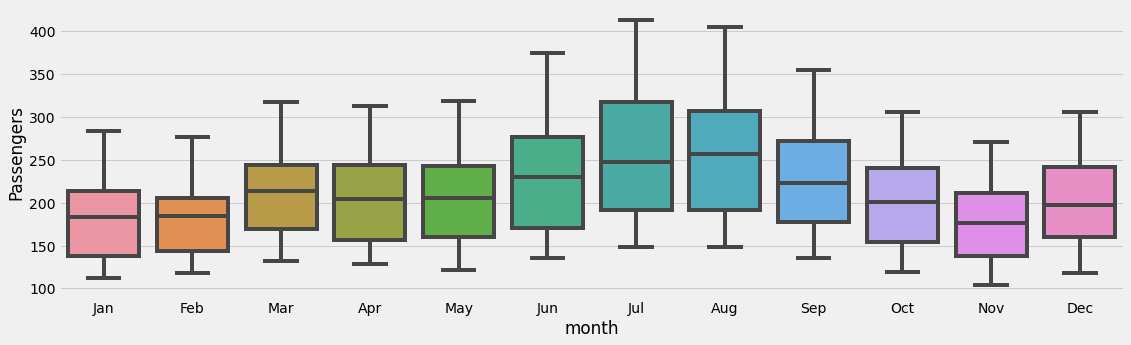

In [14]:
sns.boxplot(x="month",y="Passengers",data=dfs)

<AxesSubplot:xlabel='year', ylabel='Passengers'>

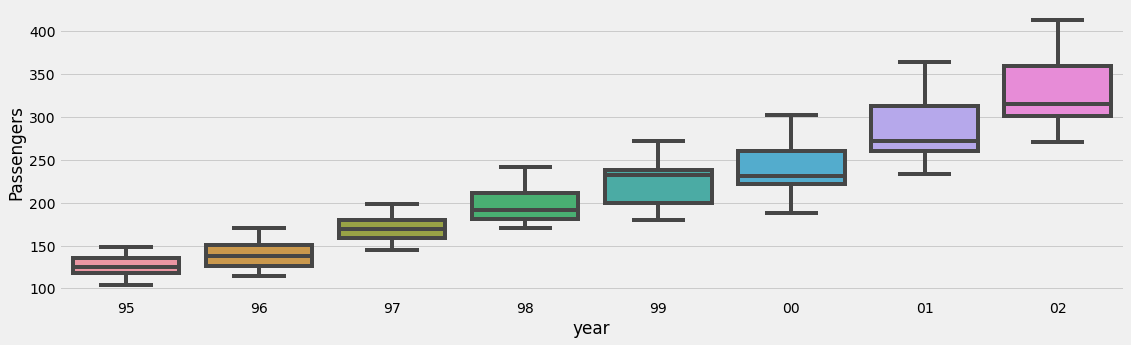

In [15]:
sns.boxplot(x="year",y="Passengers",data=dfs)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

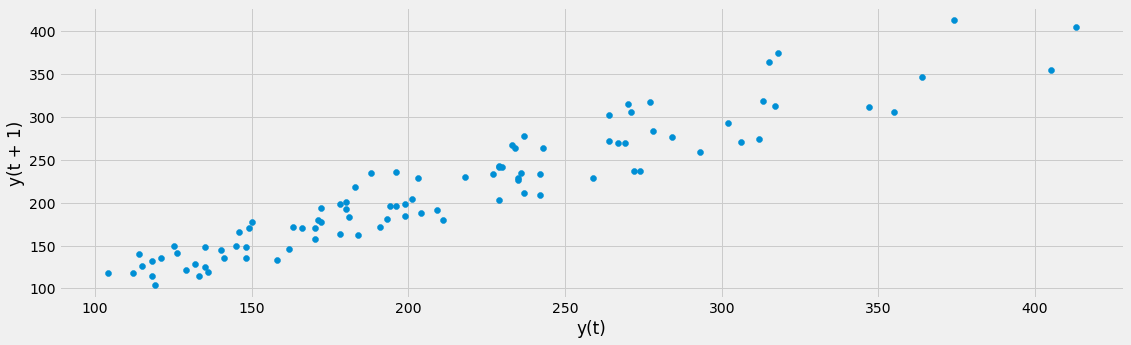

In [16]:
pd.plotting.lag_plot(dfs['Passengers'])

In [17]:
import statsmodels.graphics.tsaplots as tsa_plots

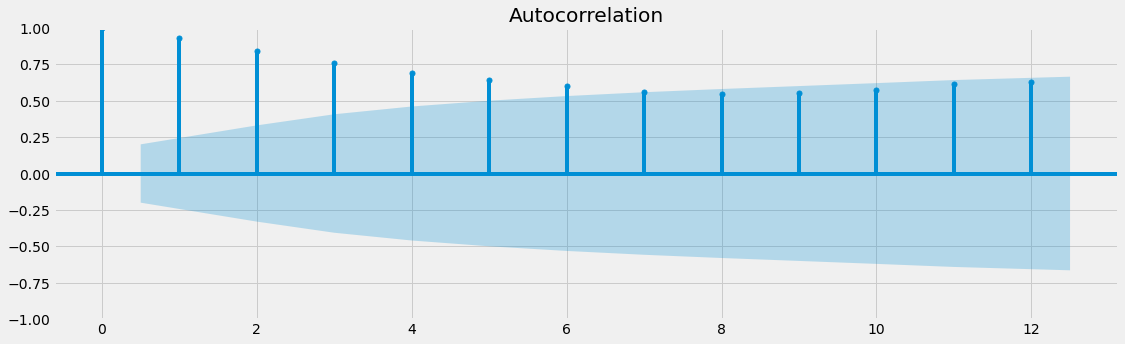

In [18]:
tsa_plots.plot_acf(dfs['Passengers'],lags=12)
plt.show()

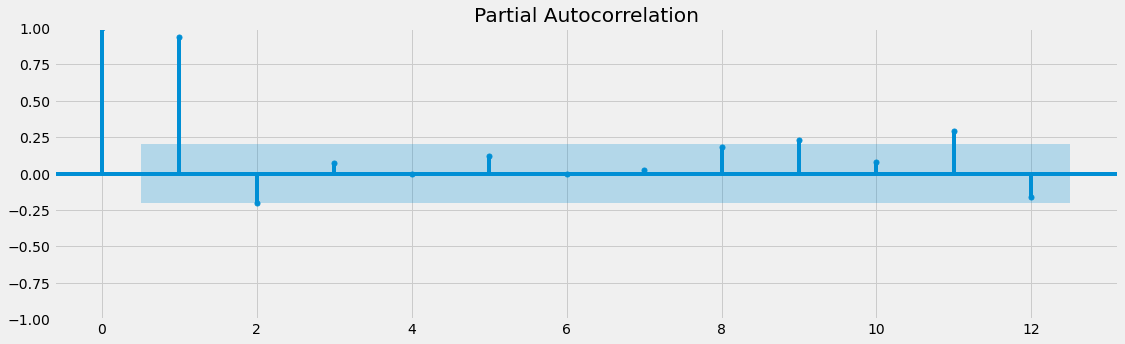

In [19]:
tsa_plots.plot_pacf(dfs['Passengers'],lags=12)
plt.show()

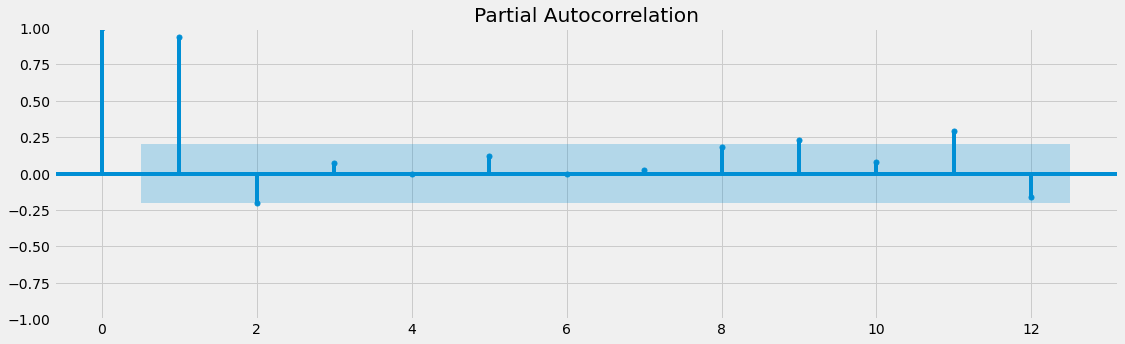

In [20]:
tsa_plots.plot_pacf(dfs['Passengers'],lags=12)
plt.show()

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

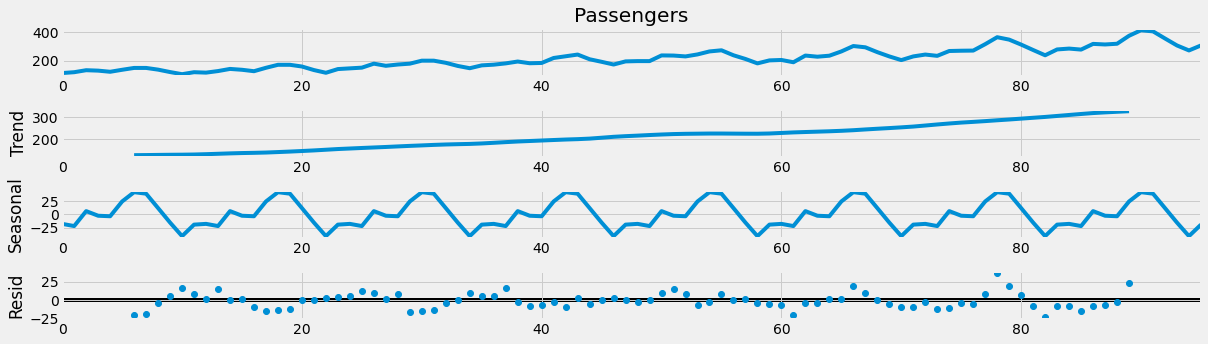

In [22]:
ts_decompose = seasonal_decompose(dfs['Passengers'],period = 12)
ts_decompose.plot()
plt.show()

In [23]:
train = dfs.head(75)
test = dfs.tail(25)

In [24]:
train.tail()

,Month,Passengers,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,year,t,t_sqr,log_passengers
70,2000-11-01,203,Nov,0,0,0,0,0,0,0,0,0,1,0,0,00,71,5041,5.313206
71,2000-12-01,229,Dec,0,0,1,0,0,0,0,0,0,0,0,0,00,72,5184,5.433722
72,2001-01-01,242,Jan,0,0,0,0,1,0,0,0,0,0,0,0,01,73,5329,5.488938
73,2001-02-01,233,Feb,0,0,0,1,0,0,0,0,0,0,0,0,01,74,5476,5.451038
74,2001-03-01,267,Mar,0,0,0,0,0,0,0,1,0,0,0,0,01,75,5625,5.587249


In [25]:
test.head()

,Month,Passengers,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,year,t,t_sqr,log_passengers
71,2000-12-01,229,Dec,0,0,1,0,0,0,0,0,0,0,0,0,00,72,5184,5.433722
72,2001-01-01,242,Jan,0,0,0,0,1,0,0,0,0,0,0,0,01,73,5329,5.488938
73,2001-02-01,233,Feb,0,0,0,1,0,0,0,0,0,0,0,0,01,74,5476,5.451038
74,2001-03-01,267,Mar,0,0,0,0,0,0,0,1,0,0,0,0,01,75,5625,5.587249
75,2001-04-01,269,Apr,1,0,0,0,0,0,0,0,0,0,0,0,01,76,5776,5.594711


<AxesSubplot:xlabel='month', ylabel='Passengers'>

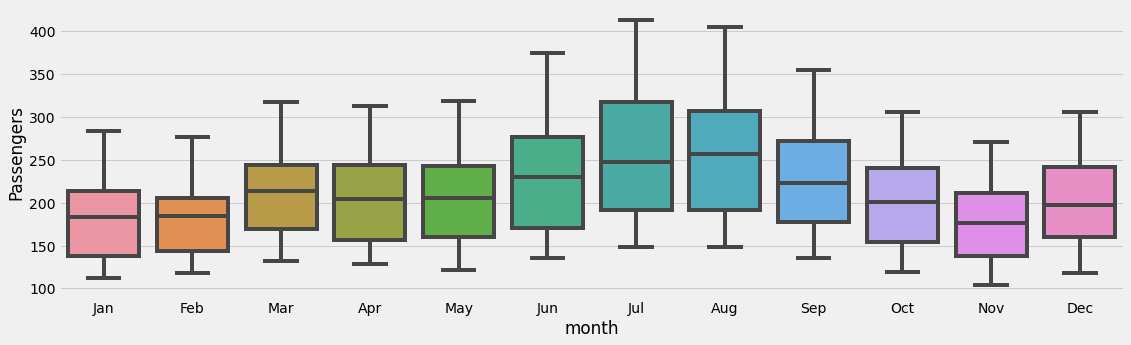

In [26]:
sns.boxplot(x="month",y="Passengers",data=dfs)

### Model based forecasting

In [27]:
import statsmodels.formula.api as smf

### linear model

In [28]:
lnr_model = smf.ols('Passengers~t',data = train).fit()
pred_lnr = pd.Series(lnr_model.predict(pd.DataFrame(test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_lnr))**2))
print('RMSE Linear:',rmse_linear)

RMSE Linear: 51.838097495845105


### Exponential model

In [29]:
exp_model = smf.ols('log_passengers~t',data = train).fit()
pred_exp = pd.Series(exp_model.predict(pd.DataFrame(test['t'])))
rmse_exponential = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(np.exp(pred_exp)))**2))
print('RMSE exponential:',rmse_exponential)

RMSE exponential: 42.775259750197996


### Quadratic model

In [30]:
qd_model = smf.ols('Passengers~t+t_sqr',data=train).fit()
pred_qd =  pd.Series(qd_model.predict(pd.DataFrame(test[['t','t_sqr']])))
rmse_quadratic = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_qd))**2))
print("RMSE Quadratic: ",rmse_quadratic)

RMSE Quadratic:  54.03140645625272


### Additive seasonality

In [31]:
add_sea_model = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train).fit()
pred_add_sea =  pd.Series(add_sea_model.predict(pd.DataFrame(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']])))
rmse_additive_seasonality = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_add_sea))**2))
print("RMSE Additive seasonality: ",rmse_additive_seasonality)

RMSE Additive seasonality:  123.02763788084242


### Additive seasonality quadratic

In [32]:
add_sea_qd_model = smf.ols('Passengers~t+t_sqr+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train).fit()
pred_add_sea_qd =  pd.Series(add_sea_qd_model.predict(pd.DataFrame(test[['t','t_sqr','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']])))
rmse_additive_seasonality_quadratic = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_add_sea_qd))**2))
print("RMSE Additive seasonality quadratic: ",rmse_additive_seasonality_quadratic)

RMSE Additive seasonality quadratic:  36.53627444546833


### Multiplicative seasonalty

In [33]:
mult_sea_model = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train).fit()
pred_mult_sea =  pd.Series(mult_sea_model.predict(test))
rmse_multiplicative_seasonality = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(np.exp(pred_mult_sea)))**2))
print("RMSE Multiplicative seasonality: ",rmse_multiplicative_seasonality)

RMSE Multiplicative seasonality:  128.16622817596138


### Multiplicative additive seasonality

In [34]:
mult_add_sea_model = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train).fit()
pred_mult_add_sea =  pd.Series(mult_add_sea_model.predict(test))
rmse_multiplicative_add_sea = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(np.exp(pred_mult_add_sea)))**2))
print("RMSE Multiplicative additive seasonality: ",rmse_multiplicative_add_sea)

RMSE Multiplicative additive seasonality:  11.565825437686113


### Data driven forecasting

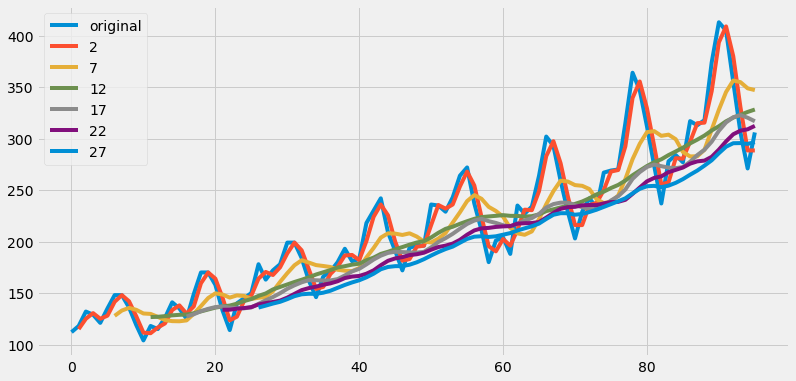

In [35]:
plt.figure(figsize=(12,6))
dfs['Passengers'].plot(label='original')
for i in range(2,30,5):
    dfs['Passengers'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best') 

### Simple exponential smoothing model

In [36]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,Holt,Holt,ExponentialSmoothing

In [37]:
ses_model = SimpleExpSmoothing(train['Passengers']).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start=test.index[0],end=test.index[-1])
ses_rmse = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_ses))**2))
ses_rmse

77.71310757781525

### Holt model

In [38]:
holt_model = Holt(train['Passengers']).fit(smoothing_level=0.8,smoothing_slope=0.2)
pred_holt = holt_model.predict(start=test.index[0],end=test.index[-1])
holt_rmse = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_holt))**2))
holt_rmse

42.88281154093843

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [39]:
hwe_model_m_a = ExponentialSmoothing(train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_m_a = hwe_model_m_a.predict(start = test.index[0],end = test.index[-1])

hw_ma_rms=np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_hwe_m_a))**2))
hw_ma_rms

35.70611843485386

### Holts winter exponential smoothing with additive seasonality and multiplicative trend

In [40]:
hwe_model_a_m = ExponentialSmoothing(train["Passengers"],seasonal="add",trend="mul",seasonal_periods=12).fit() 
pred_hwe_a_m = hwe_model_a_m.predict(start = test.index[0],end = test.index[-1])

hw_am_rms=np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_hwe_a_m))**2))
hw_am_rms

39.423890915962595

### Holts winter exponential smoothing with additive seasonality and additive trend

In [41]:
hwe_model_a_a = ExponentialSmoothing(train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() 
pred_hwe_a_a = hwe_model_a_a.predict(start = test.index[0],end = test.index[-1])

hw_aa_rms=np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_hwe_a_a))**2))
hw_aa_rms

40.85163532253417

## To check the stationary

### Implementation of ADF Test

In [42]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np

In [43]:
path = 'Database/Airlines+Data.xlsx'
df= pd.read_excel(path, index_col='Month')

In [44]:
df.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


### Plotting the data.

<AxesSubplot:title={'center':'alcohol data series'}, xlabel='Month'>

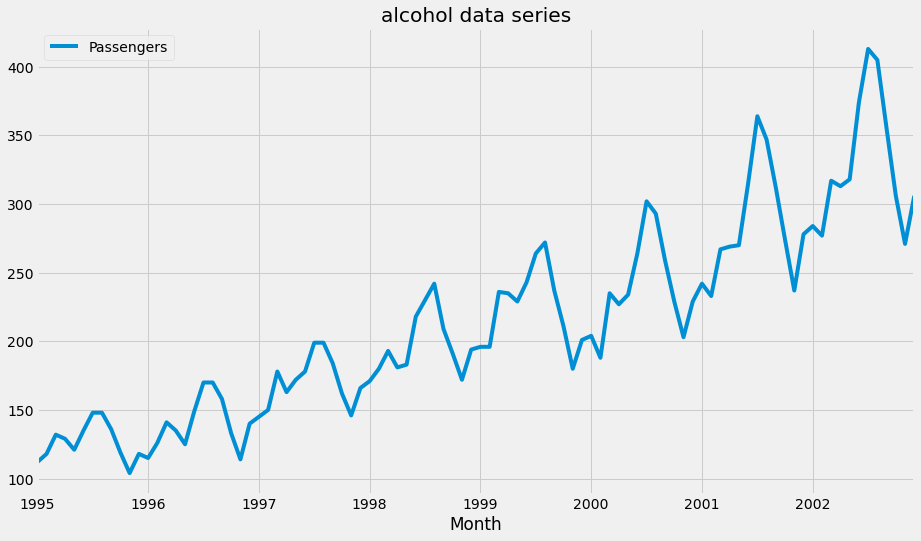

In [45]:
df.plot(figsize=(14,8), title='alcohol data series')

In [46]:
series = df['Passengers'].values
series

array([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115,
       126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150,
       178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193,
       181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235,
       229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234,
       264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270, 315,
       364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374, 413,
       405, 355, 306, 271, 306], dtype=int64)

### Performing the ADF test on the series:

In [47]:
# ADF Test
result = adfuller(series, autolag='AIC')

### Extracting the values from the results:

In [48]:
print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: 1.340248
p-value: 0.996825
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586
Failed to Reject Ho - Time Series is Non-Stationary


#### Here in the results, we can see that the p-value for time series is greater than 0.05, and we can say we fail to reject the null hypothesis and the time series is non-stationary.

## Define Functions

In [49]:
def ADF(data):
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]}')
    print(f'n_lags: {result[2]}')
    print(f'p-value: {result[1]:.20f}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
                        
# -------------------------------------------------------------
def ACF_and_PACF(data):
    fig = plt.figure(figsize=(17,10))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(data, lags=30, ax=ax1) 
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(data, lags=30, ax=ax2)

## Preprocessing

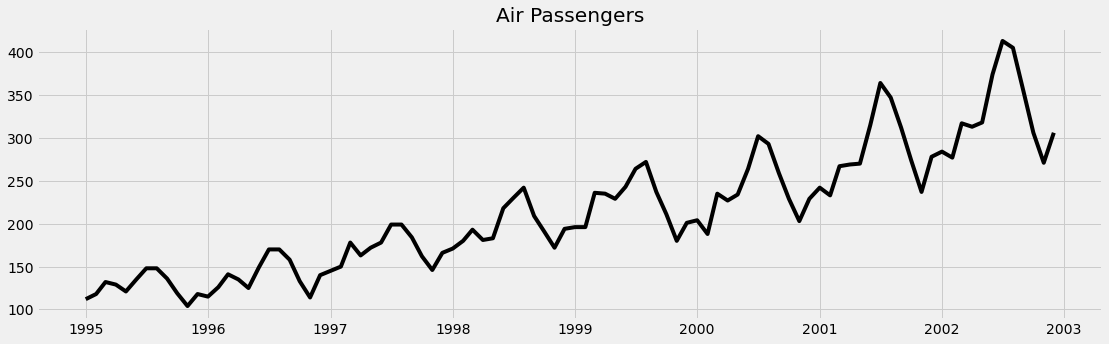

In [50]:
plt.plot(df,color='black')
plt.title("Air Passengers")
plt.show()

<AxesSubplot:xlabel='Passengers'>

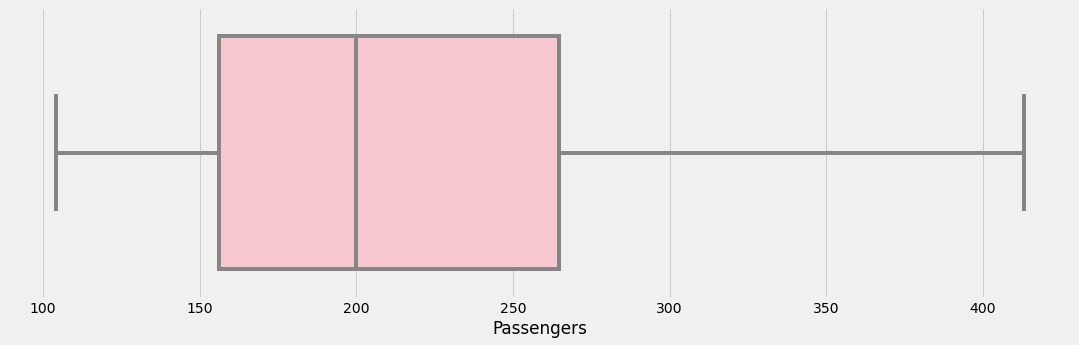

In [51]:
sns.boxplot(df['Passengers'], color='pink')

<AxesSubplot:xlabel='Passengers', ylabel='Density'>

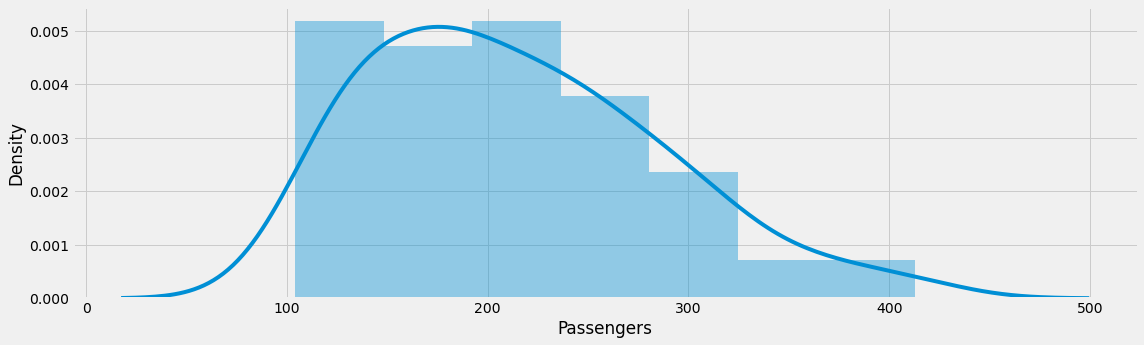

In [52]:
sns.distplot(df['Passengers'])

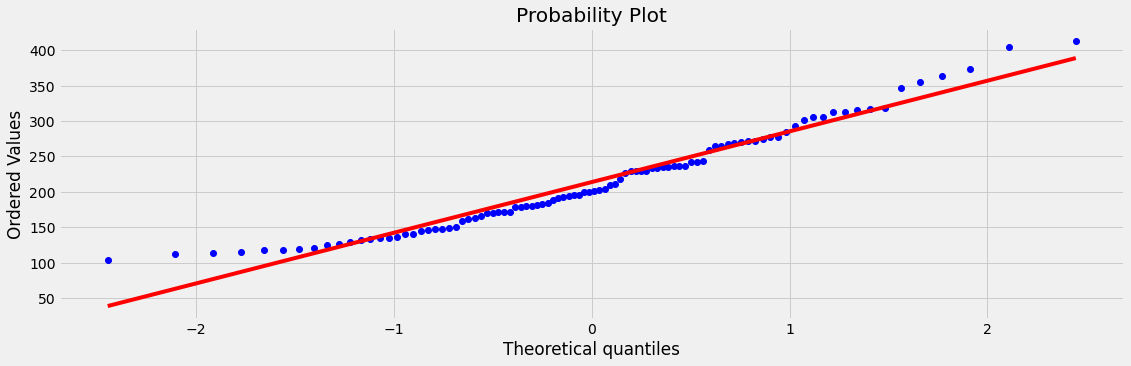

In [53]:
stats.probplot(df['Passengers'],plot=pylab)
pylab.show()

In [54]:
length_train = math.floor(len(df["Passengers"])*0.8)

train = df[:length_train]
test = df[length_train:]

## Decomposition

--------------------------------------------------
                     additive
-------------------------------------------------- 



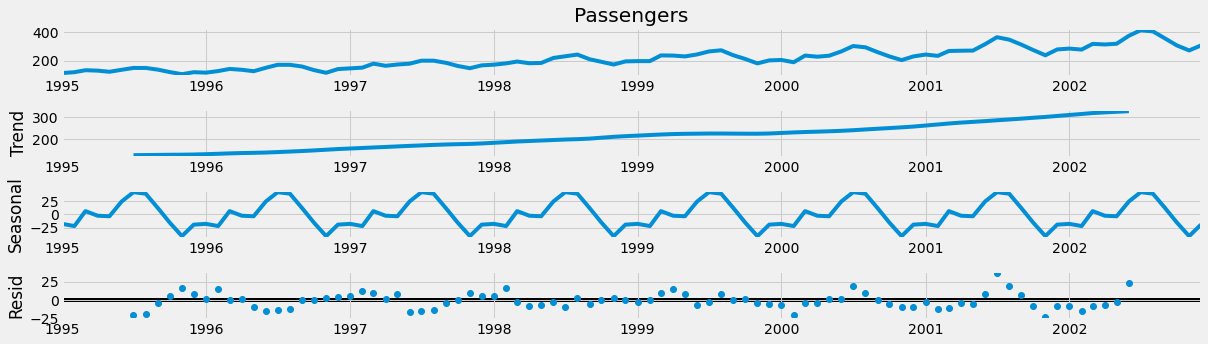



 --------------------------------------------------
                     multiplicative
-------------------------------------------------- 



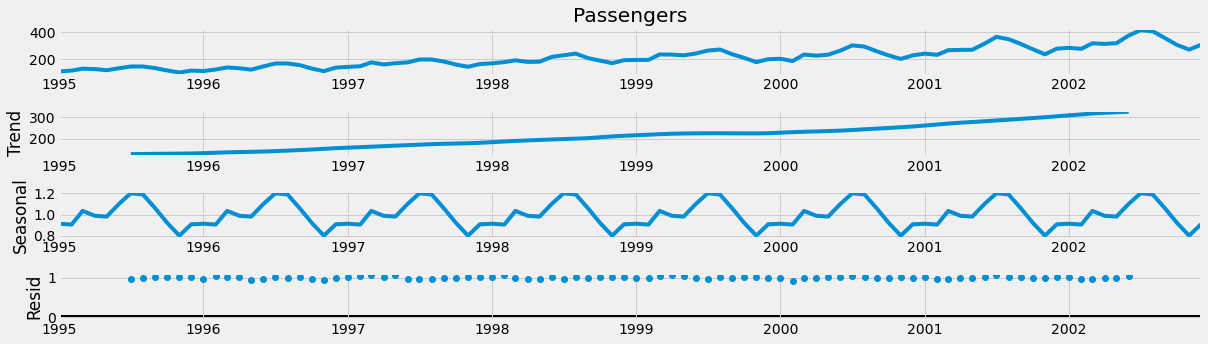

In [55]:
print('-'*50)
print(' '*20,'additive')
print('-'*50,'\n')

decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='additive')
decomposition.plot()                               
plt.show()

#----------------------------------------------------
print('\n\n','-'*50)
print(' '*20,'multiplicative')
print('-'*50,'\n')

decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')
fig = decomposition.plot()
plt.show()

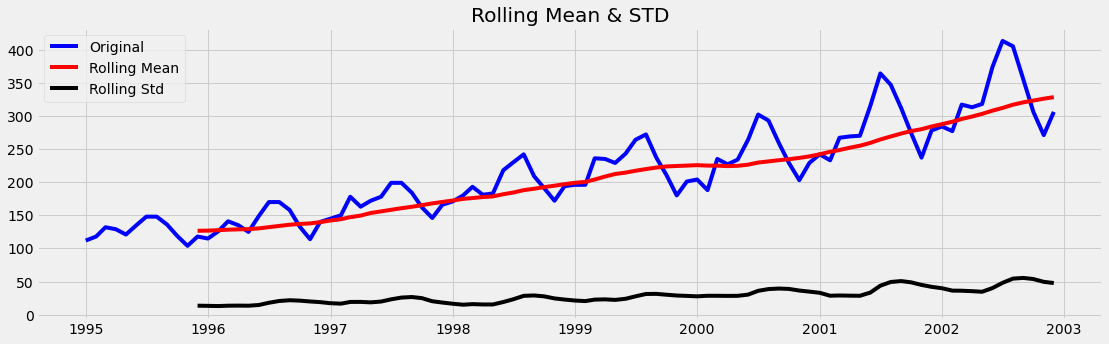

In [56]:
rolmean = df.rolling(window=12).mean()
rolstd = df.rolling(window=12).std()
orig = plt.plot(df, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean & STD')
plt.show()

In [57]:
ADF(df['Passengers'])

ADF Statistic: 1.3402479596467112
n_lags: 12
p-value: 0.99682504811372629749
Critial Values:
   1%, -3.5117123057187376
Critial Values:
   5%, -2.8970475206326833
Critial Values:
   10%, -2.5857126912469153


#### Based-on adfuller:
#### p-value = 0.99 (p-value > 0.05) --> H0 Accepted --> The data is non-stationary

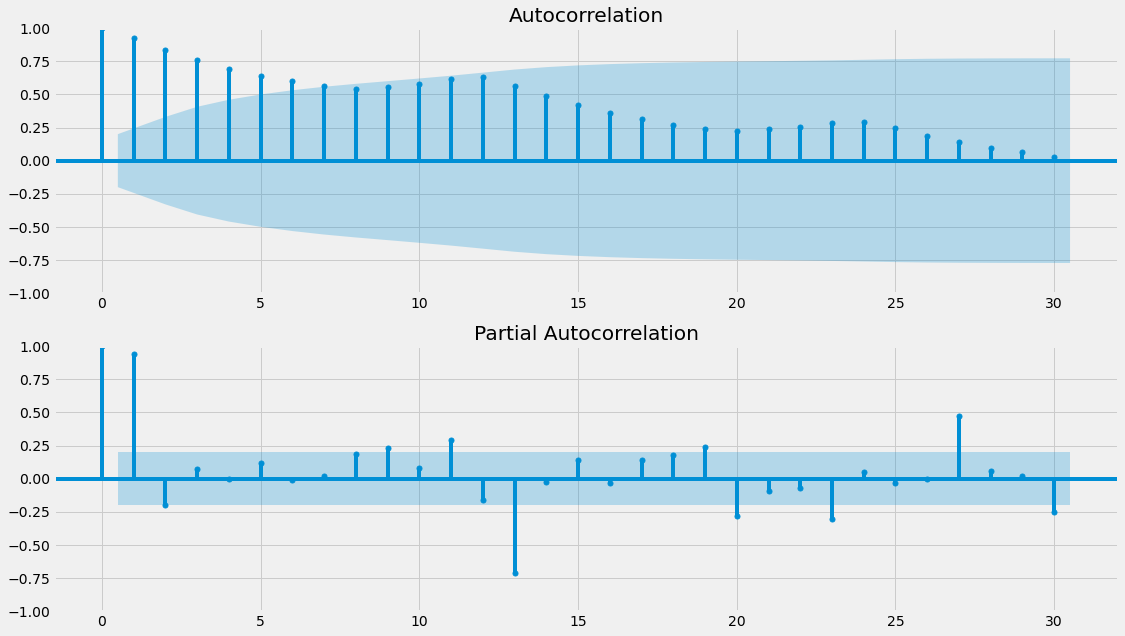

In [58]:
ACF_and_PACF(df['Passengers'])

#### In this time series, we have seasonal components and non-constant variance and mean. To eliminate these non-stationary, we do the following:

#### Elimination non-constant variance
#### Elimination seasonal components
#### Elimination non-constant mean

### Elimination non-constant variance with boxcox

--------------------------------------------------
      fitted_lambda is:  -0.016139945909494486
-------------------------------------------------- 



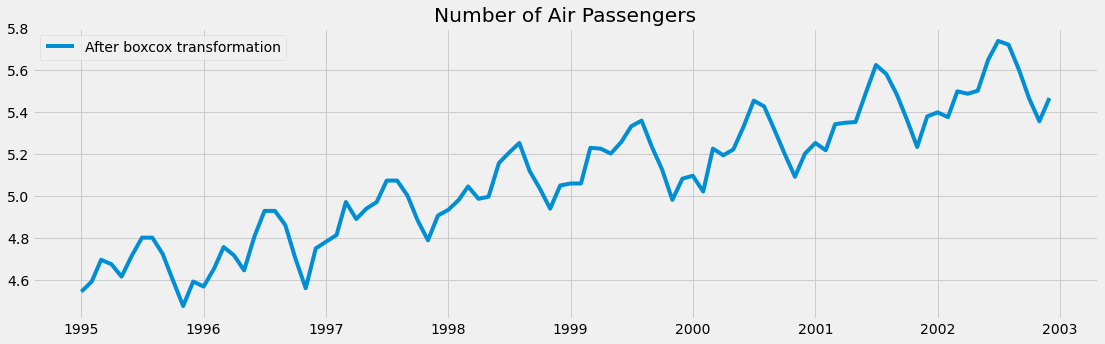

In [59]:
fitted_data, fitted_lambda = stats.boxcox(df['Passengers'])
print('-'*50)
print(' '*5,'fitted_lambda is: ',fitted_lambda)
print('-'*50,'\n')

data_boxcox = pd.Series(boxcox(df['Passengers'],fitted_lambda),index=df.index)
plt.plot(data_boxcox, label="After boxcox transformation")
plt.legend()
plt.title("Number of Air Passengers")
plt.show()

In [60]:
ADF(data_boxcox)

ADF Statistic: -0.7628461270235638
n_lags: 12
p-value: 0.82979292434005436085
Critial Values:
   1%, -3.5117123057187376
Critial Values:
   5%, -2.8970475206326833
Critial Values:
   10%, -2.5857126912469153


### Elimination seasonal components with differencing

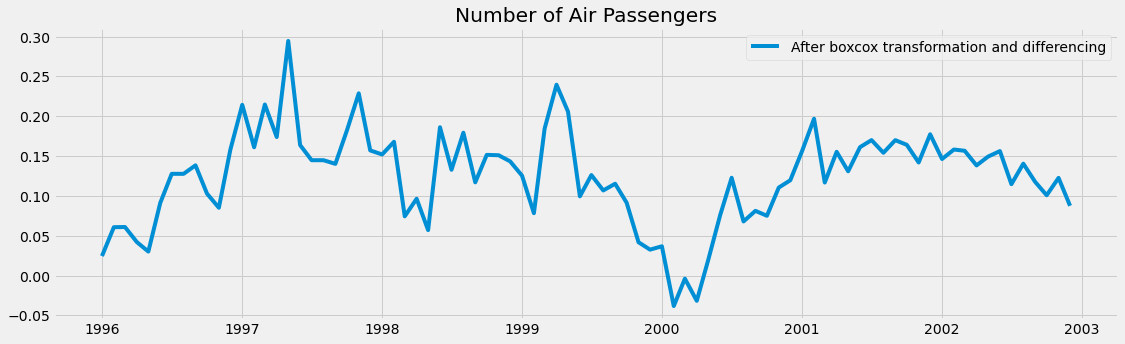

In [61]:
data_boxcox_diff_12= pd.Series(data_boxcox - data_boxcox.shift(periods=12), index=df.index)
data_boxcox_diff_12.dropna(inplace=True)

plt.plot(data_boxcox_diff_12, label="After boxcox transformation and differencing")
plt.legend()
plt.title("Number of Air Passengers")
plt.show()

In [62]:
ADF(data_boxcox_diff_12)

ADF Statistic: -2.360693713270089
n_lags: 12
p-value: 0.15313892730048622726
Critial Values:
   1%, -3.526004646825607
Critial Values:
   5%, -2.9032002348069774
Critial Values:
   10%, -2.5889948363419957


### Elimination non-constant mean with differencing

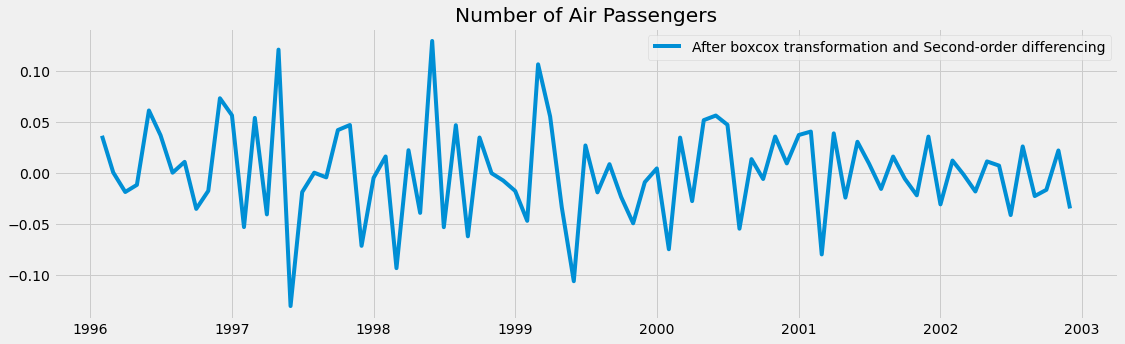

In [63]:
data_boxcox_second_order_diff= pd.Series(data_boxcox_diff_12 - data_boxcox_diff_12.shift(), index=df.index)
data_boxcox_second_order_diff.dropna(inplace=True)

plt.plot(data_boxcox_second_order_diff, label="After boxcox transformation and Second-order differencing")
plt.legend()
plt.title("Number of Air Passengers")
plt.show()

In [64]:
ADF(data_boxcox_second_order_diff)

ADF Statistic: -3.30259600351402
n_lags: 11
p-value: 0.01476283110597306769
Critial Values:
   1%, -3.526004646825607
Critial Values:
   5%, -2.9032002348069774
Critial Values:
   10%, -2.5889948363419957


### Based-on adfuller:
### p-value < 0.05 --> H0 Reject --> The data is stationary

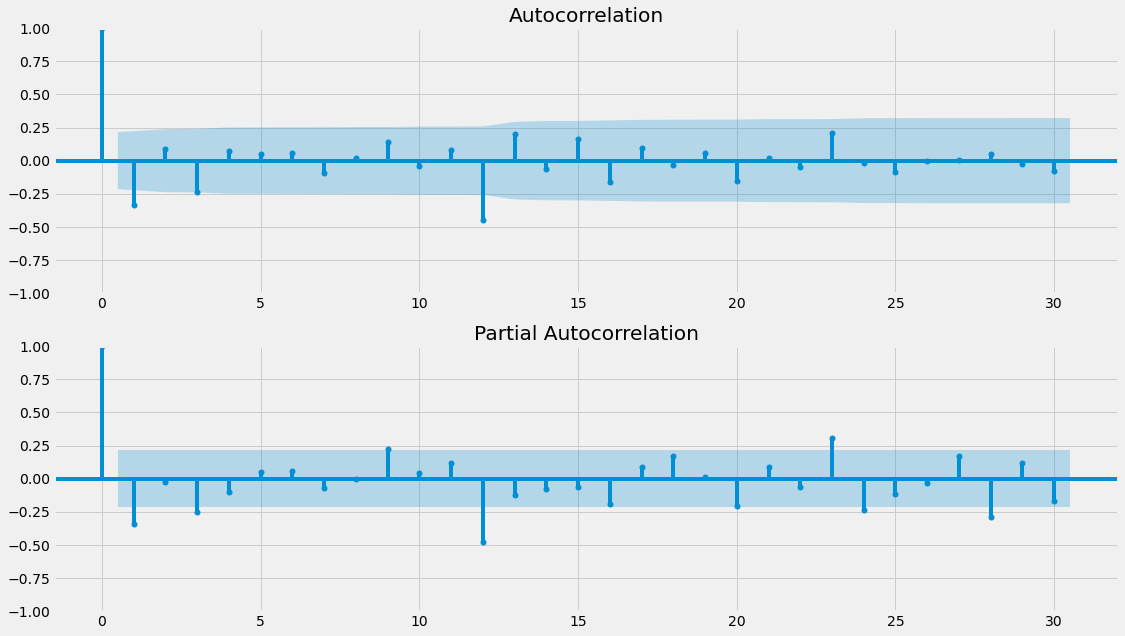

In [65]:
ACF_and_PACF(data_boxcox_second_order_diff)

## Modeling

In [66]:
train_boxcox_second_order_diff = data_boxcox_second_order_diff[:length_train]
test_boxcox_second_order_diff = data_boxcox_second_order_diff[length_train:]

In [67]:
train_boxcox_second_order_diff.tail()

Month
2002-01-01   -0.031061
2002-02-01    0.011910
2002-03-01   -0.001556
2002-04-01   -0.018391
2002-05-01    0.011053
Name: Passengers, dtype: float64

In [68]:
test_boxcox_second_order_diff.head()

Month
2002-06-01    0.006949
2002-07-01   -0.041534
2002-08-01    0.025752
2002-09-01   -0.022901
2002-10-01   -0.016762
Name: Passengers, dtype: float64

## AR

In [69]:
model_ar = ARIMA(train_boxcox_second_order_diff, order=(12,0,0))
model_fit_ar = model_ar.fit()
model_fit_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                   76
Model:                ARIMA(12, 0, 0)   Log Likelihood                 139.432
Date:                Tue, 06 Sep 2022   AIC                           -250.864
Time:                        22:01:26   BIC                           -218.234
Sample:                    02-01-1996   HQIC                          -237.824
                         - 05-01-2002                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.003      0.339      0.735      -0.005       0.007
ar.L1         -0.3428      0.111     -3.092      0.002      -0.560      -0.126
ar.L2         -0.0769      0.145     -0.530      0.596      -0.361       0.207
ar.L3         -0.1843      0.141     -1.309      0.190      -0.460       0.092
ar.L4         -0.0538      0.151     -0.356      0.722      -0.350       0.242
ar.L5          0.0218      0.105      0.208      0.836      -0.184       0.227
ar.L6          0.0410      0.118      0.347      0.728      -0.190       0.272
ar.L7         -0.0019      0.139     -0.014      0.989      -0.274       0.270
ar.L8          0.0335      0.117      0.286      0.775      -0.196       0.263
ar.L9          0.0757      0.124      0.610      0.542      -0.167       0.319
ar.L10         0.0494      0.130      0.380      0.704      -0.205       0.304
ar.L11        -0.0778      0.121     -0.643      0.520      -0.315       0.159
ar.L12        -0.4090      0.119     -3.425      0.001      -0.643      -0.175
sigma2         0.0014      0.000      5.335      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.74   Prob(JB):                         0.90
Heteroskedasticity (H):               0.54   Skew:                             0.12
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Transformation

In [70]:
predictions_AR_diff = pd.Series(model_fit_ar.fittedvalues, copy=True)
print(predictions_AR_diff.head())

Month
1996-02-01    0.001030
1996-03-01   -0.010475
1996-04-01    0.000252
1996-05-01   -0.000320
1996-06-01    0.005637
dtype: float64


In [71]:
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
print(predictions_AR_diff_cumsum)

Month
1996-02-01    0.001030
1996-03-01   -0.009446
1996-04-01   -0.009194
1996-05-01   -0.009513
1996-06-01   -0.003876
                ...   
2002-01-01   -0.003747
2002-02-01    0.001046
2002-03-01    0.027693
2002-04-01    0.020132
2002-05-01    0.035283
Length: 76, dtype: float64


In [72]:
predictions_AR_boxcox = pd.Series(data_boxcox, index=data_boxcox.index)
predictions_AR_boxcox

Month
1995-01-01    4.543303
1995-02-01    4.591641
1995-03-01    4.695356
1995-04-01    4.674105
1995-05-01    4.614882
                ...   
2002-08-01    5.722164
2002-09-01    5.602437
2002-10-01    5.467173
2002-11-01    5.356317
2002-12-01    5.467173
Name: Passengers, Length: 96, dtype: float64

In [73]:
predictions_AR_boxcox = pd.Series(data_boxcox, index=data_boxcox.index)
predictions_AR_boxcox = predictions_AR_boxcox.add(predictions_AR_diff_cumsum, fill_value=0)
predictions_AR_boxcox.head()

Month
1995-01-01    4.543303
1995-02-01    4.591641
1995-03-01    4.695356
1995-04-01    4.674105
1995-05-01    4.614882
dtype: float64

In [74]:
predictions_AR = inv_boxcox(predictions_AR_boxcox, fitted_lambda)
predictions_AR.head()

Month
1995-01-01    112.0
1995-02-01    118.0
1995-03-01    132.0
1995-04-01    129.0
1995-05-01    121.0
dtype: float64

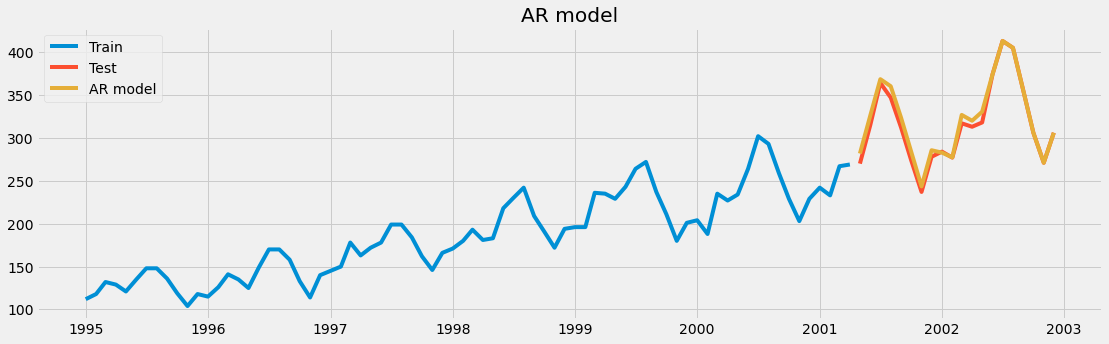

In [75]:
plt.plot(train['Passengers'], label = 'Train')
plt.plot(test['Passengers'], label = 'Test')
plt.plot(predictions_AR[test.index.min():], label = 'AR model')

plt.legend()
plt.title('AR model')
plt.show()

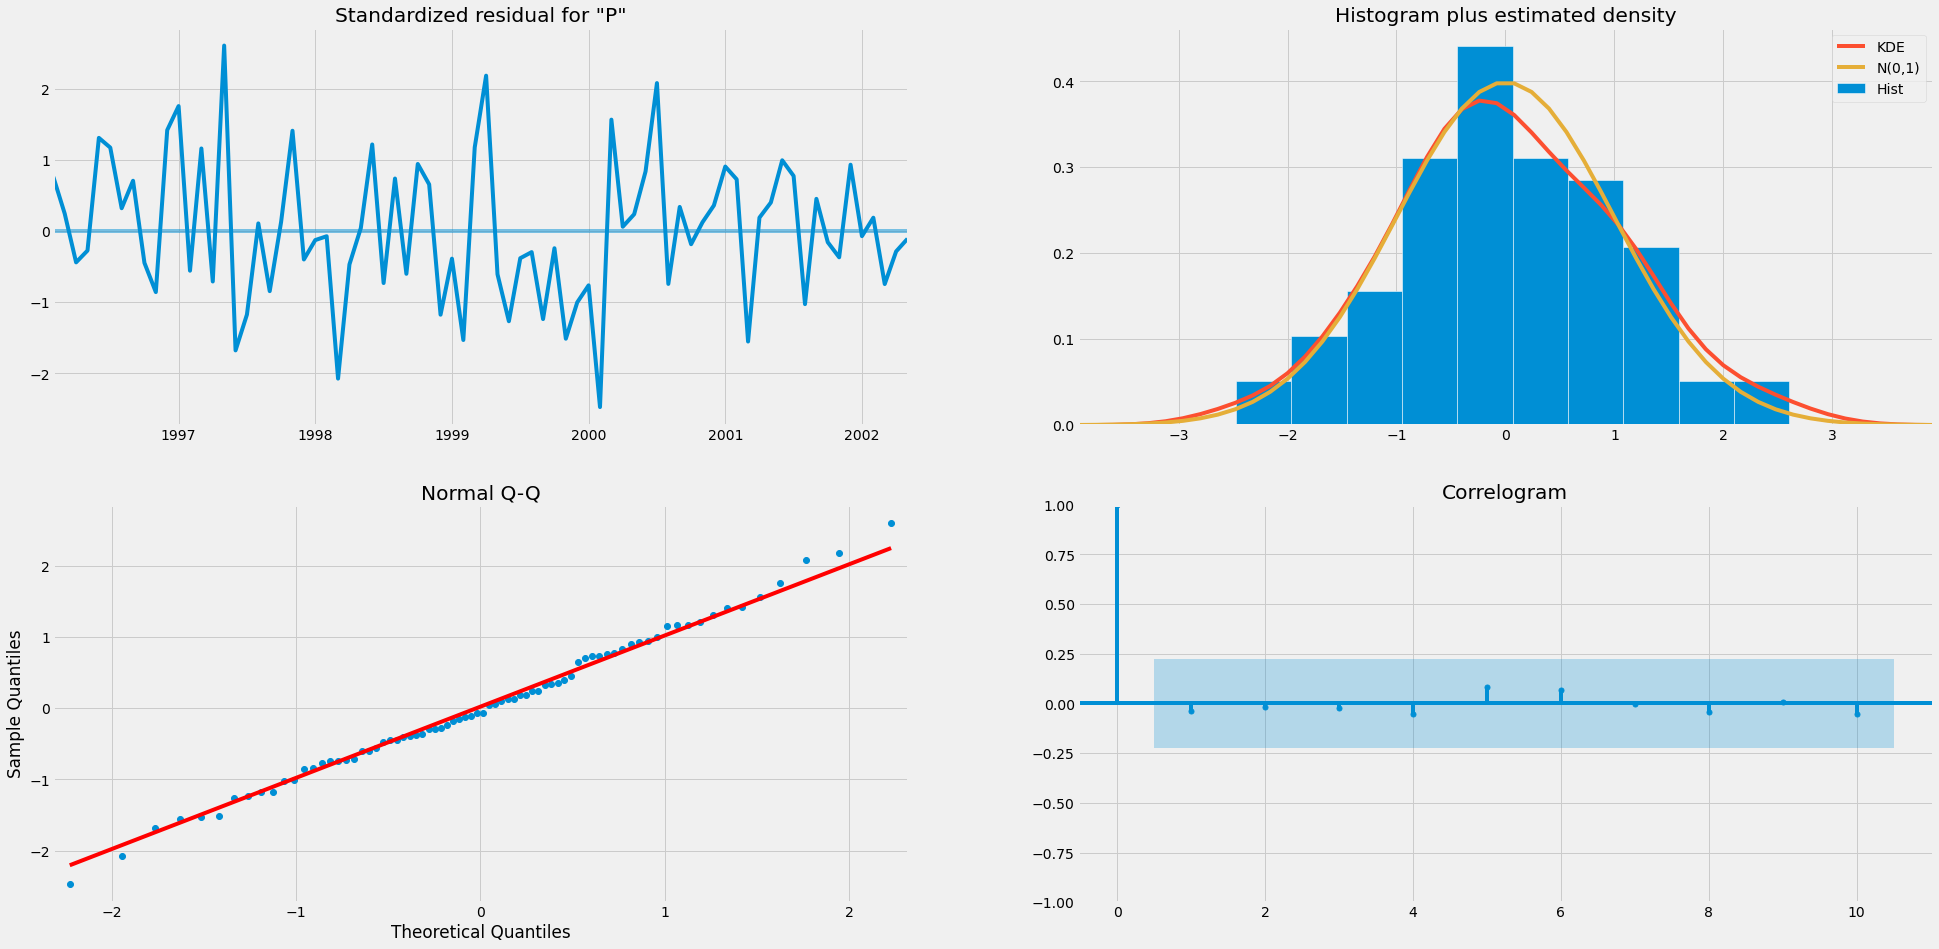

In [76]:
x = model_fit_ar.plot_diagnostics(figsize=(30,15))

## MA

In [77]:
model_ma = ARIMA(train_boxcox_second_order_diff, order=(0,0,12))
model_fit_ma = model_ma.fit()
model_fit_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                   76
Model:                ARIMA(0, 0, 12)   Log Likelihood                 140.786
Date:                Tue, 06 Sep 2022   AIC                           -253.571
Time:                        22:01:30   BIC                           -220.941
Sample:                    02-01-1996   HQIC                          -240.531
                         - 05-01-2002                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.154      0.878      -0.003       0.004
ma.L1         -0.3073      0.209     -1.469      0.142      -0.717       0.103
ma.L2          0.0520      0.214      0.243      0.808      -0.367       0.471
ma.L3         -0.2050      0.195     -1.053      0.293      -0.587       0.177
ma.L4         -0.0407      0.195     -0.209      0.834      -0.422       0.341
ma.L5          0.1654      0.140      1.184      0.236      -0.108       0.439
ma.L6          0.0078      0.239      0.033      0.974      -0.461       0.477
ma.L7         -0.0049      0.221     -0.022      0.982      -0.438       0.428
ma.L8         -0.1130      0.181     -0.625      0.532      -0.467       0.241
ma.L9          0.0107      0.222      0.048      0.961      -0.424       0.445
ma.L10         0.0303      0.251      0.121      0.904      -0.461       0.522
ma.L11         0.0940      0.221      0.425      0.671      -0.339       0.527
ma.L12        -0.5860      0.196     -2.992      0.003      -0.970      -0.202
sigma2         0.0013      0.000      4.433      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.46   Prob(JB):                         0.83
Heteroskedasticity (H):               0.64   Skew:                            -0.05
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Transformation

In [78]:
pred_MA_diff = pd.Series(model_fit_ma.fittedvalues, copy=True)
pred_MA_diff_cumsum = pred_MA_diff.cumsum()

pred_MA_boxcox = pd.Series(data_boxcox, index=data_boxcox.index)
pred_MA_boxcox = pred_MA_boxcox.add(pred_MA_diff_cumsum, fill_value=0)

pred_MA = inv_boxcox(pred_MA_boxcox, fitted_lambda)

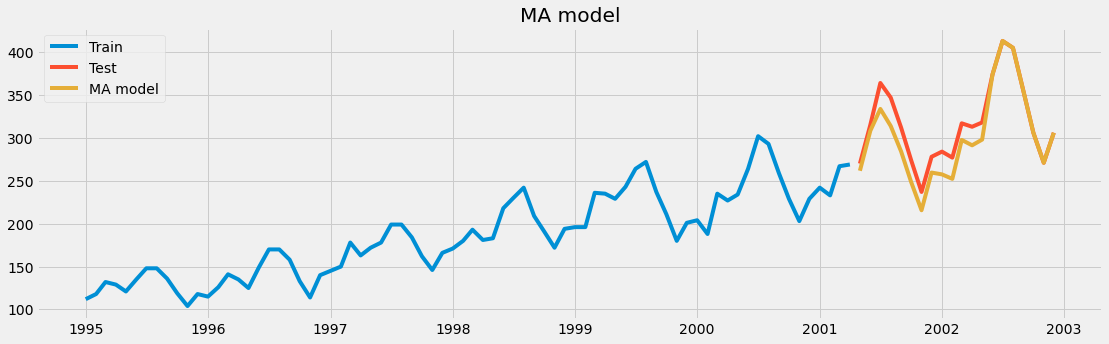

In [79]:
plt.plot(train['Passengers'], label = 'Train')
plt.plot(test['Passengers'], label = 'Test')
plt.plot(pred_MA[test.index.min():], label = 'MA model')

plt.legend()
plt.title('MA model')
plt.show()

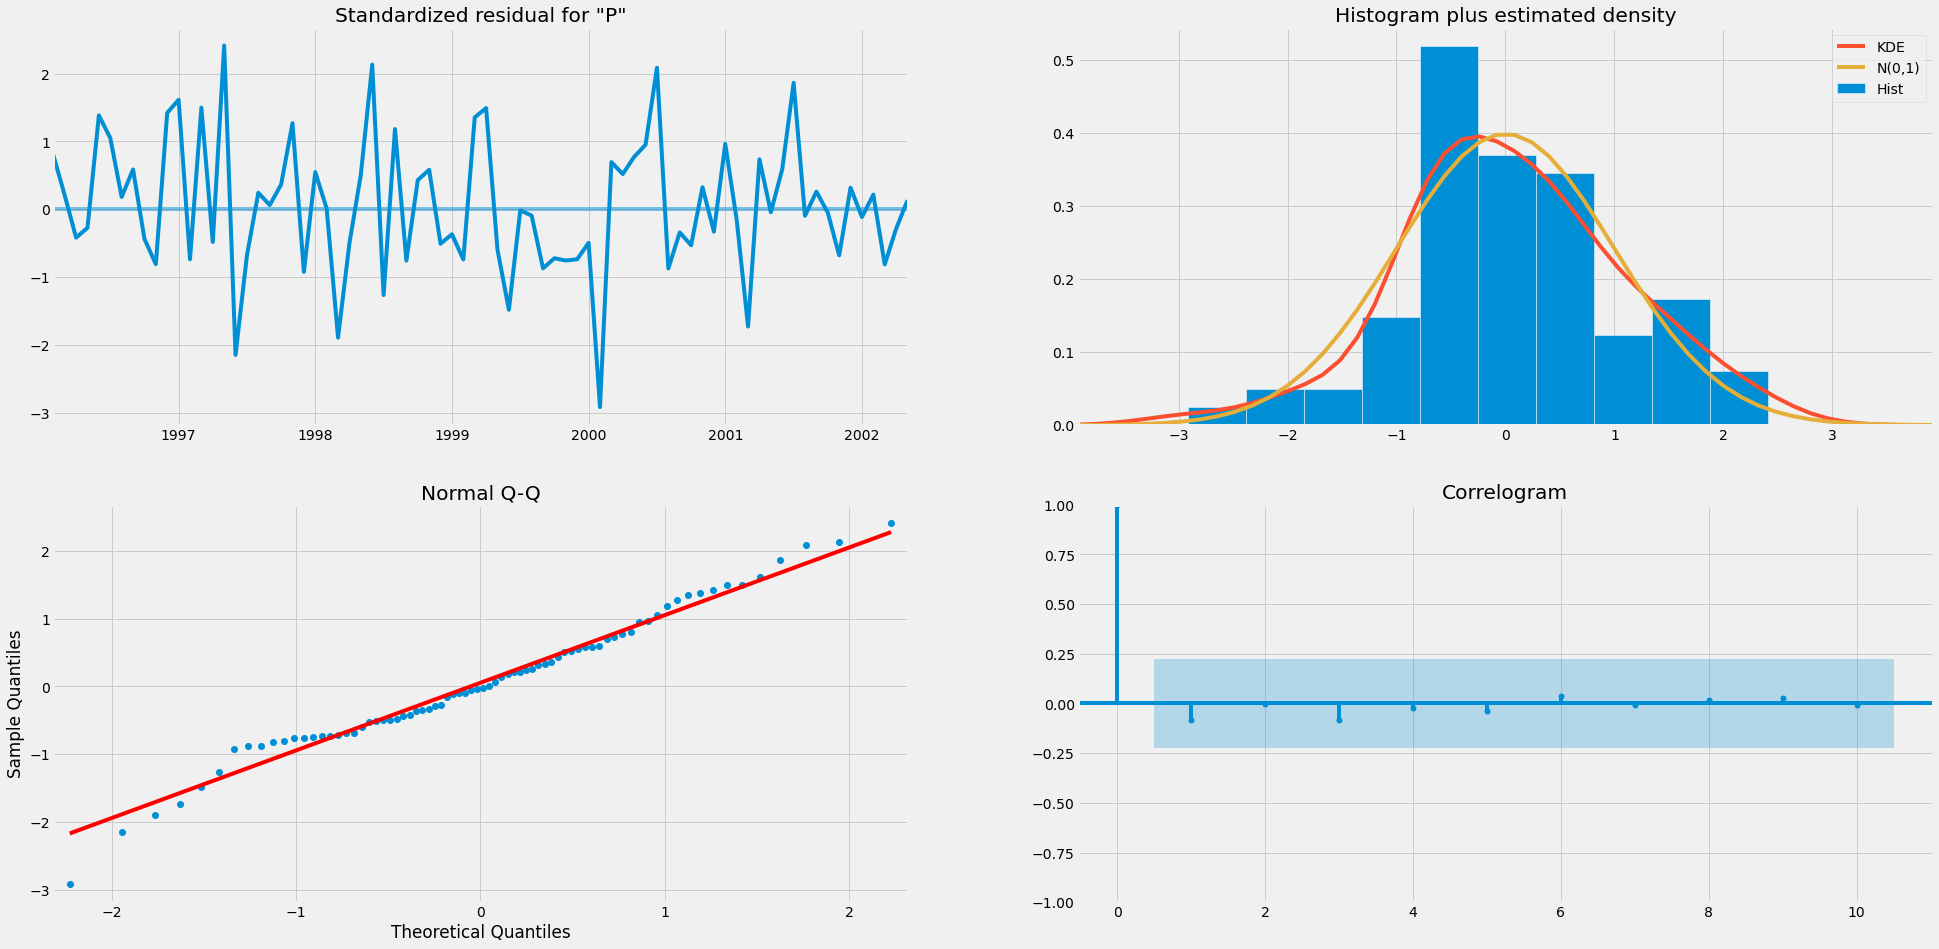

In [80]:
x = model_fit_ma.plot_diagnostics(figsize=(30,15))

## ARMA

In [81]:
model_arma = ARIMA(train_boxcox_second_order_diff, order=(6,0,6))
model_fit_arma = model_arma.fit()
model_fit_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                   76
Model:                 ARIMA(6, 0, 6)   Log Likelihood                 137.723
Date:                Tue, 06 Sep 2022   AIC                           -247.446
Time:                        22:01:32   BIC                           -214.815
Sample:                    02-01-1996   HQIC                          -234.405
                         - 05-01-2002                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.005      0.195      0.845      -0.008       0.010
ar.L1         -0.1289      0.281     -0.459      0.646      -0.679       0.421
ar.L2          0.2213      0.234      0.946      0.344      -0.237       0.680
ar.L3         -0.7295      0.248     -2.942      0.003      -1.216      -0.243
ar.L4          0.3442      0.239      1.437      0.151      -0.125       0.814
ar.L5          0.1406      0.245      0.574      0.566      -0.339       0.621
ar.L6         -0.5979      0.221     -2.706      0.007      -1.031      -0.165
ma.L1         -0.1715      0.288     -0.596      0.551      -0.735       0.392
ma.L2         -0.1808      0.435     -0.415      0.678      -1.034       0.672
ma.L3          0.5739      0.250      2.296      0.022       0.084       1.064
ma.L4         -0.5760      0.567     -1.016      0.309      -1.687       0.535
ma.L5          0.2806      0.297      0.946      0.344      -0.301       0.862
ma.L6          0.6129      0.434      1.413      0.158      -0.237       1.463
sigma2         0.0015      0.001      2.455      0.014       0.000       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.72   Prob(JB):                         0.67
Heteroskedasticity (H):               0.61   Skew:                             0.25
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Transformation

In [82]:
pred_ARMA_diff = pd.Series(model_fit_arma.fittedvalues, copy=True)
pred_ARMA_diff_cumsum = pred_ARMA_diff.cumsum()

pred_ARMA_boxcox = pd.Series(data_boxcox, index=data_boxcox.index)
pred_ARMA_boxcox = pred_ARMA_boxcox.add(pred_ARMA_diff_cumsum, fill_value=0)

pred_ARMA = inv_boxcox(pred_ARMA_boxcox, fitted_lambda)

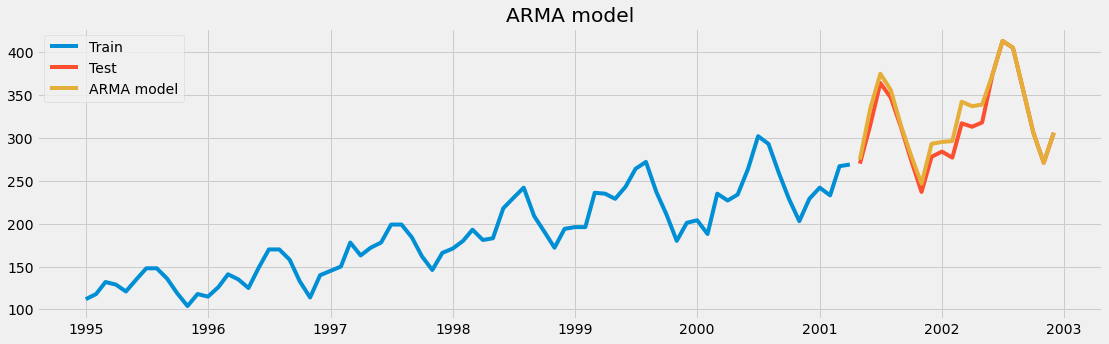

In [83]:
plt.plot(train['Passengers'], label = 'Train')
plt.plot(test['Passengers'], label = 'Test')
plt.plot(pred_ARMA[test.index.min():], label = 'ARMA model')

plt.legend()
plt.title('ARMA model')
plt.show()

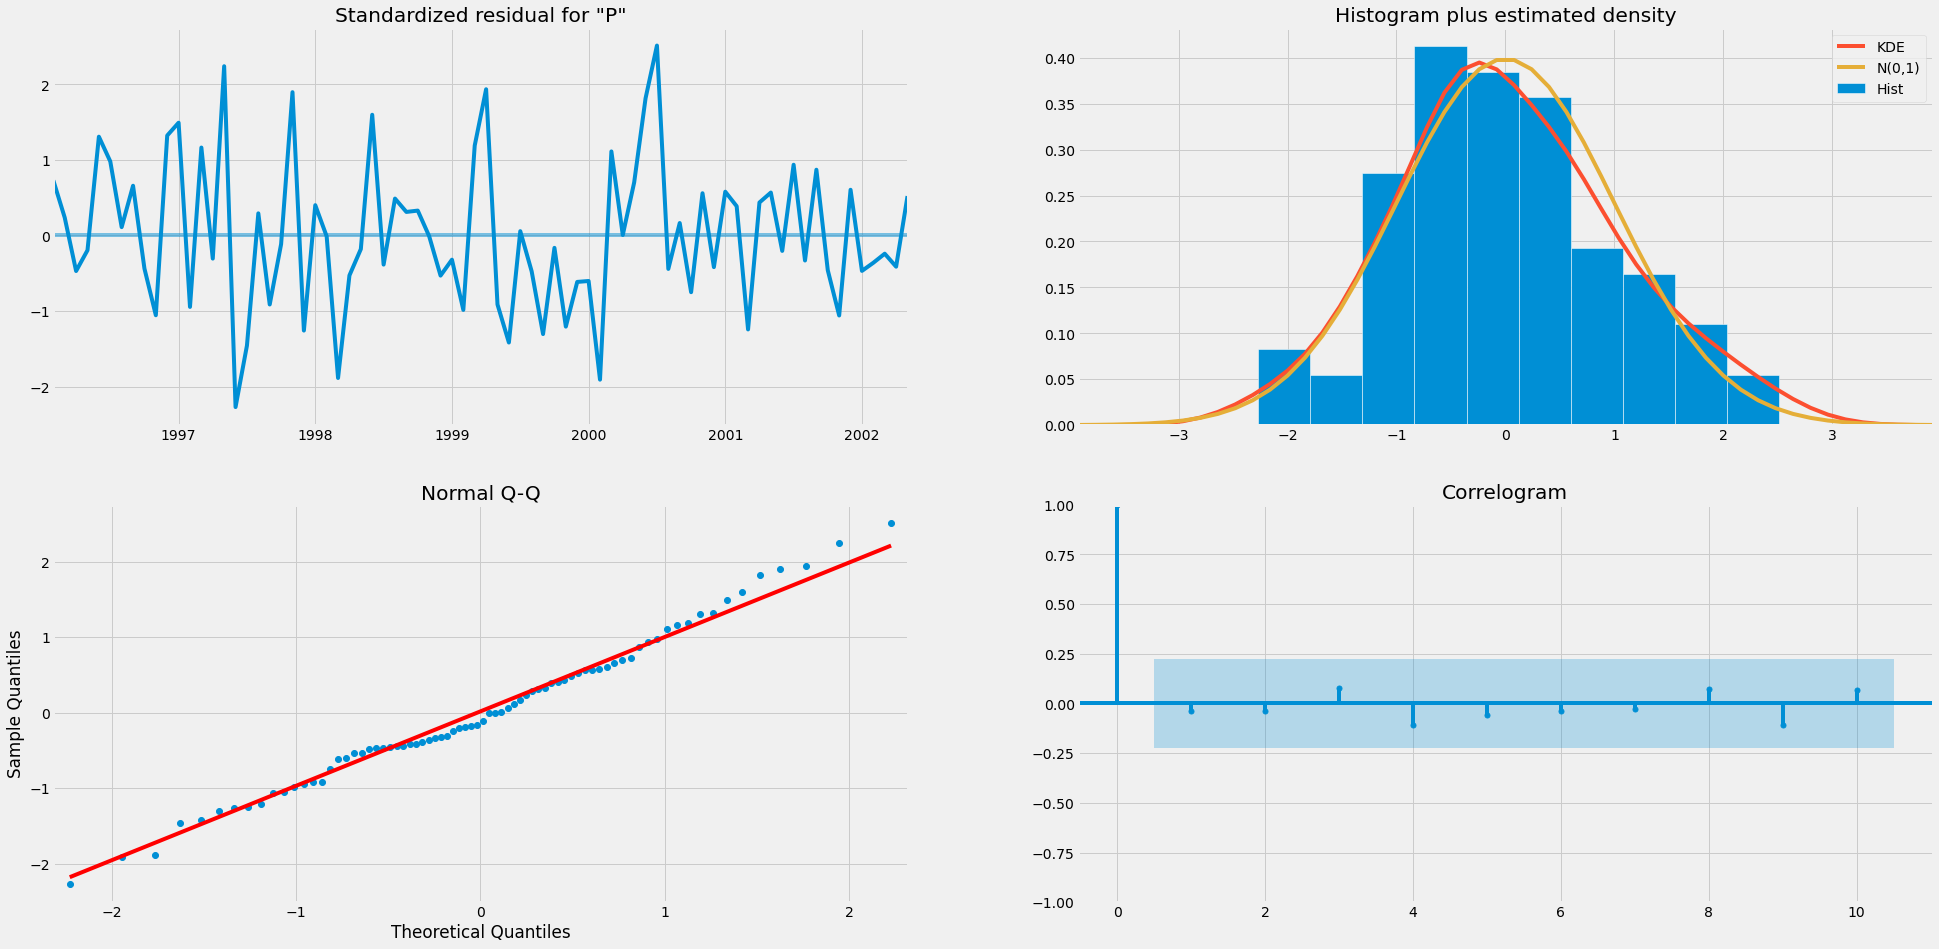

In [84]:
x = model_fit_arma.plot_diagnostics(figsize=(30,15))

## ARIMA

In [85]:
model_arima = ARIMA(train_boxcox_second_order_diff, order=(6,1,6))
model_fit_arima = model_arima.fit()
model_fit_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                   76
Model:                 ARIMA(6, 1, 6)   Log Likelihood                 131.969
Date:                Tue, 06 Sep 2022   AIC                           -237.938
Time:                        22:01:36   BIC                           -207.810
Sample:                    02-01-1996   HQIC                          -225.908
                         - 05-01-2002                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4711      1.127     -1.305      0.192      -3.680       0.738
ar.L2         -1.3380      2.070     -0.646      0.518      -5.396       2.720
ar.L3         -1.5928      1.991     -0.800      0.424      -5.495       2.309
ar.L4         -0.9040      2.076     -0.435      0.663      -4.973       3.165
ar.L5         -0.1958      1.502     -0.130      0.896      -3.139       2.747
ar.L6         -0.1246      0.422     -0.295      0.768      -0.952       0.703
ma.L1          0.2147      1.437      0.149      0.881      -2.601       3.030
ma.L2         -0.2158      1.730     -0.125      0.901      -3.606       3.174
ma.L3          0.1277      1.250      0.102      0.919      -2.323       2.579
ma.L4         -0.9112      1.378     -0.661      0.508      -3.611       1.789
ma.L5         -0.3715      1.099     -0.338      0.735      -2.526       1.783
ma.L6          0.1633      0.852      0.192      0.848      -1.506       1.833
sigma2         0.0015      0.002      0.762      0.446      -0.002       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 0.08
Prob(Q):                              0.68   Prob(JB):                         0.96
Heteroskedasticity (H):               0.45   Skew:                             0.07
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Transformation

In [86]:
pred_ARIMA_diff = pd.Series(model_fit_arima.fittedvalues, copy=True)
pred_ARIMA_diff_cumsum = pred_ARIMA_diff.cumsum()

pred_ARIMA_boxcox = pd.Series(data_boxcox, index=data_boxcox.index)
pred_ARIMA_boxcox = pred_ARIMA_boxcox.add(pred_ARIMA_diff_cumsum, fill_value=0)

pred_ARIMA = inv_boxcox(pred_ARIMA_boxcox, fitted_lambda)

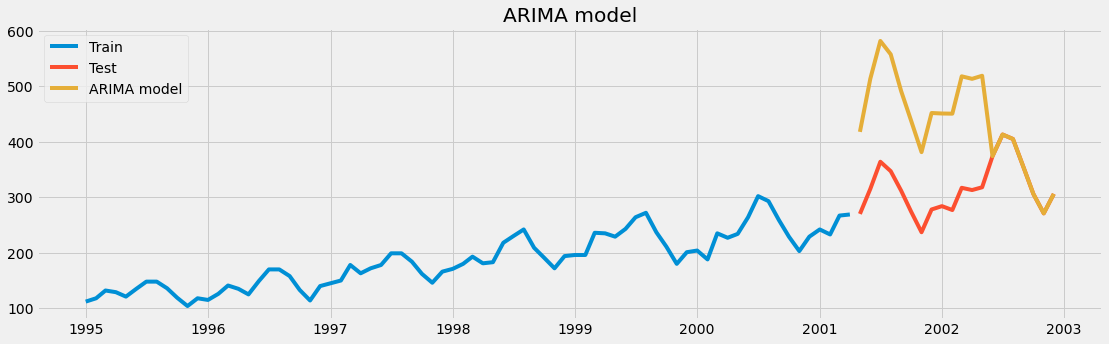

In [87]:
plt.plot(train['Passengers'], label = 'Train')
plt.plot(test['Passengers'], label = 'Test')
plt.plot(pred_ARIMA[test.index.min():], label = 'ARIMA model')

plt.legend()
plt.title('ARIMA model')
plt.show()

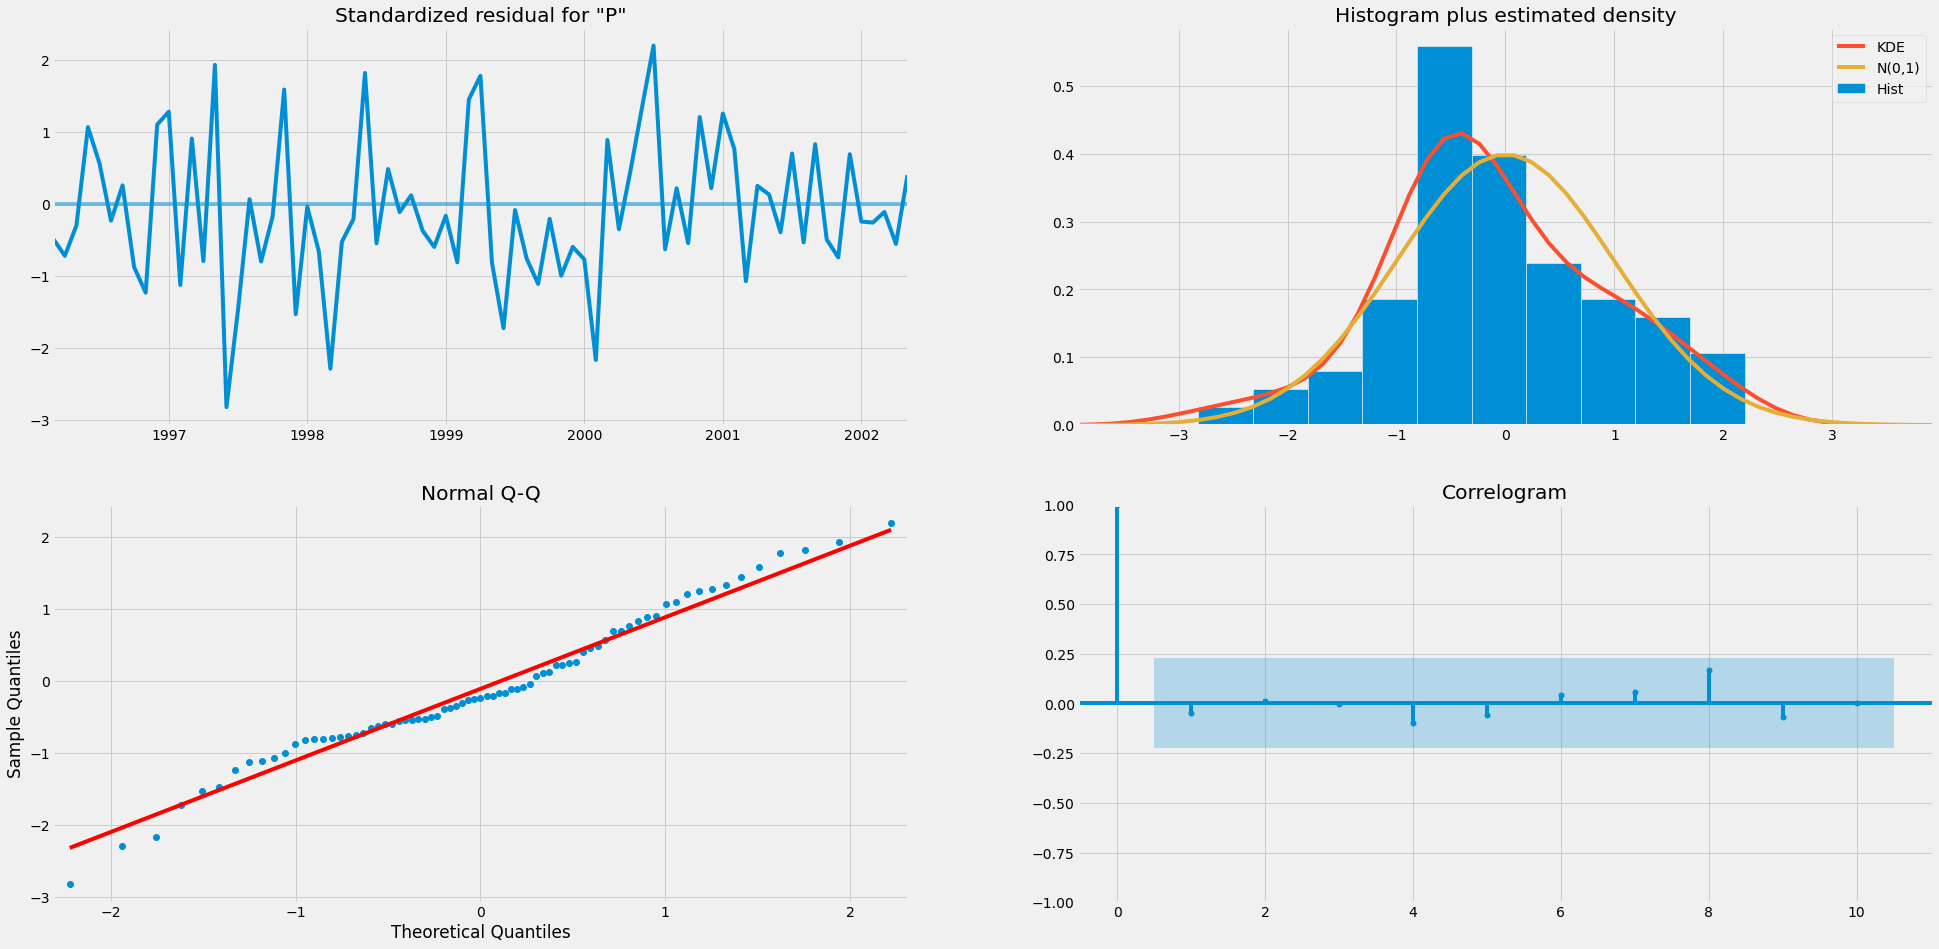

In [88]:
x = model_fit_arima.plot_diagnostics(figsize=(30,15))

## SARIMA

In [89]:
model_auto_sarima = auto_arima(train_boxcox_second_order_diff, start_p=1, start_q=1, d=1, 
                              max_p=12, max_q=12, max_d=6, D=1, start_P=1, start_Q=1,max_D=6,
                               max_P=6, max_Q=6, m=12, seasonal=True,
                              error_action='warn', suppress_warnings=True, random_state=100)
model_auto_sarima

ARIMA(order=(4, 1, 1), scoring_args={}, seasonal_order=(1, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [90]:
model_sarima = SARIMAX(train_boxcox_second_order_diff, order=(4,1,1), seasonal_order=(1,1,2,12))
model_fit_sarima = model_sarima.fit()
model_fit_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                              Passengers   No. Observations:                   76
Model:             SARIMAX(4, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                  93.415
Date:                                 Tue, 06 Sep 2022   AIC                           -168.831
Time:                                         22:21:44   BIC                           -149.543
Sample:                                     02-01-1996   HQIC                          -161.245
                                          - 05-01-2002                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4416      0.154     -2.865      0.004      -0.744      -0.139
ar.L2         -0.1919      0.177     -1.086      0.277      -0.538       0.154
ar.L3         -0.2826      0.155     -1.822      0.068      -0.587       0.021
ar.L4         -0.1575      0.160     -0.984      0.325      -0.471       0.156
ma.L1         -0.9178      0.133     -6.898      0.000      -1.179      -0.657
ar.S.L12      -0.1161      0.696     -0.167      0.867      -1.479       1.247
ma.S.L12      -1.1884      0.702     -1.693      0.090      -2.564       0.187
ma.S.L24       0.3432      0.839      0.409      0.682      -1.301       1.987
sigma2         0.0019      0.002      1.064      0.287      -0.002       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.95   Prob(JB):                         0.64
Heteroskedasticity (H):               0.42   Skew:                             0.23
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Transformation

In [91]:
pred_SARIMA_diff = pd.Series(model_fit_sarima.fittedvalues, copy=True)
pred_SARIMA_diff_cumsum = pred_SARIMA_diff.cumsum()

pred_SARIMA_boxcox = pd.Series(data_boxcox, index=data_boxcox.index)
pred_SARIMA_boxcox = pred_SARIMA_boxcox.add(pred_SARIMA_diff_cumsum, fill_value=0)

pred_SARIMA = inv_boxcox(pred_SARIMA_boxcox, fitted_lambda)

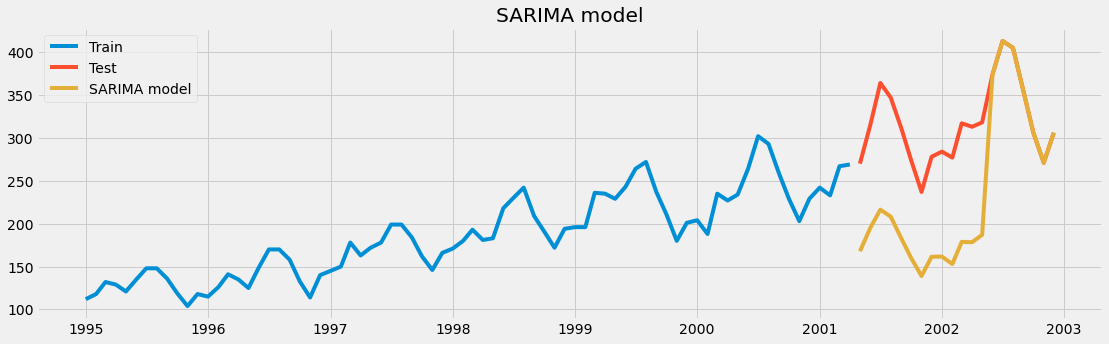

In [92]:
plt.plot(train['Passengers'], label = 'Train')
plt.plot(test['Passengers'], label = 'Test')
plt.plot(pred_SARIMA[test.index.min():], label = 'SARIMA model')

plt.legend()
plt.title('SARIMA model')
plt.show()

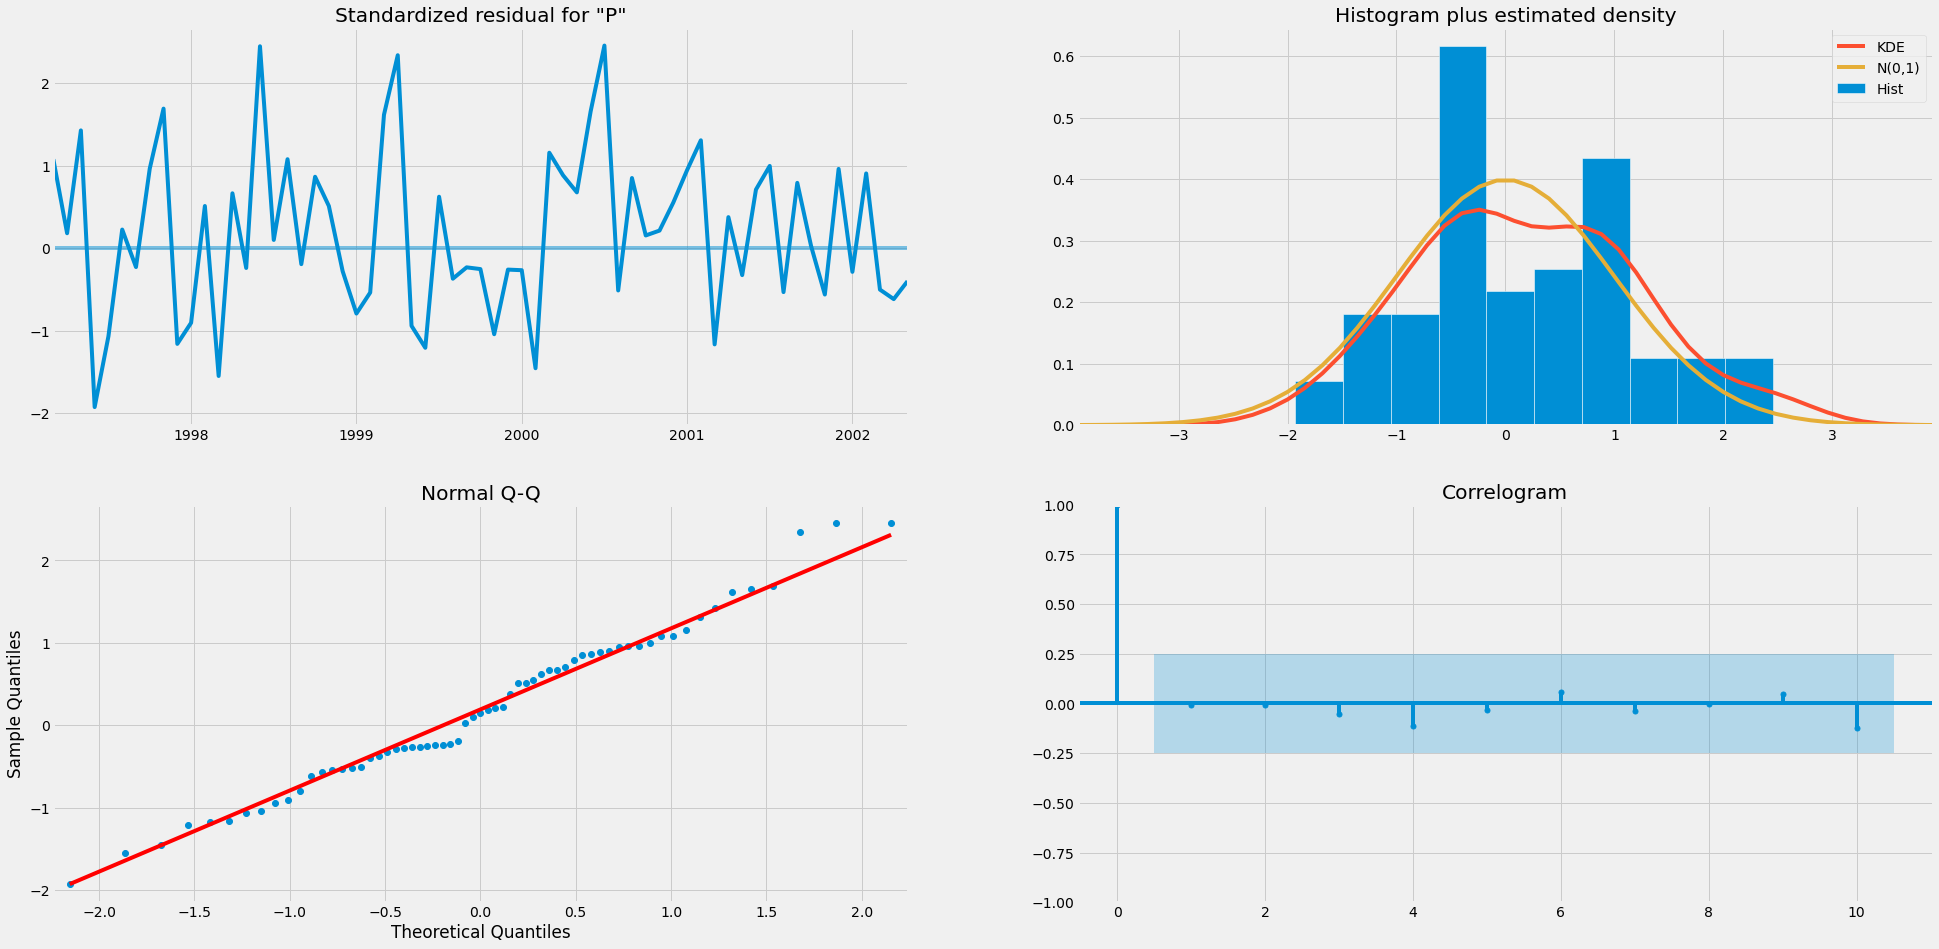

In [93]:
x = model_fit_sarima.plot_diagnostics(figsize=(30,15))